# Health insurance analysis

Choosing the right health insurance can be overwhelming with so many options. Here we used unsupervised learning to cluster health insurance plans that are offered to US government employees. We found **insert findings here**. 

The raw dataset is available from the United States Office of Personnel Management [here](https://www.opm.gov/healthcare-insurance/healthcare/plan-information/compare-plans/fehb/Plans?FFSSearch=on&Medicare=False&ZipCode=22209&IncludeNationwide=True&empType=a&payPeriod=c). We copy/pasted it into a .csv file, and cleaned up the data in this Jupyter Notebook. 

**Disclaimer:** The findings here provide an understanding of how health insurance plans are organized and priced. These findings do not consitute a recommendation, and also do not incorporate key details about the plans, such as the size of provider network, that might be important to one's decision. 

## TOC:

* [Load and clean data](#load-data)
* Data Exploration
  * [Deductibles and premiums in HMO vs. PPO](#hmo-ppo)
* Unsupervised Learning
  * Can we recover HMO vs. PPO groups using unsupervised learning?


## Load and clean data <a class = "anchor" id="load-data"></a>
1. Drops rows with NaN
2. Rename columns
3. For columns with both $ and % as values, separate into separate columns
4. For columns with 'none' replaced with '0'
5. For columns: categorize
6. Normalize data


In [1]:
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

In [2]:
# Load the data: 
df = pd.read_excel('healthcareplans.xlsx')

In [3]:
# Get a sense of data shape: 
df.shape

(380, 13)

In [4]:
# Get a few examples of data: 
# Here, we see that several rows are NaN
df.head(11)

,Plan Name (Plan Code),Plan Type,Enrollment Code,Enrollee Premium,Annual Deductible,Annual Out of Pocket Maximum,Medical Account (HRA/HSA),Primary Care Office Visit,Specialist Office Visit,Doctor Costs Inpatient Surgery,Retail Generic,Retail Brand,Plan Requires Referral to See Certain Specialists
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aetna Advantage Plan - Advantage (Z2),HMO,Z24,53.52,2000,7500,0,0.3,0.3,0.3,Tier 1: $10,Tier 2: 45%,No
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,Z26,117.74,4000,15000,0,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,Z25,141.83,4000,15000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We notice that a lot of the rows are NaN. This is because during the manual copy/paste from website to .csv file, the formatting has not been preserved. 

We'll address this by: 
* Create **df1**, which is a deep copy of our dataframe, **df**. In Python, a deep copy ensures that any changes we make to the new copy does not affect the original. 
* Change column names to make them more user friendly
* In **df1**, delete any rows where the column **Plan Type** is NaN. This filters out all the 1-person plans. 

In [5]:
# Copy dataframe
df1 = copy.deepcopy(df)

# Drop all rows where 'Plan Type' is NA value
df1 = df[df['Plan Type'].notna()]

# Change column names to make them more user-friendly
print('\n Old column names' + '-'*20 + '\n', list(df1.columns))
df1 = df1.rename(columns={"Plan Name (Plan Code)"           : "Name", 
                          "Enrollee Premium\xa0"            : "Premium",
                          "Annual Deductible\xa0"           : "Deductible", 
                          "Annual Out of Pocket Maximum\xa0": "OOP",
                          "Enrollment Code"                 : "Code", 
                          "Plan Type"                       : "Type", 
                          "Plan Requires Referral to See Certain Specialists": "Referral_req"})
print('\n New column names' + '-'*20 + '\n', list(df1.columns))

# Reset the row indexes after dropping rows
df1.reset_index(drop=True, inplace=True)

# Drop the drugs columns for now
df1 = df1.drop(columns=['Retail Generic', 'Retail Brand'])

# Aesthetic clean up: only show the first 5 letters of the Insurance Plan's company
def column_first5(df, column_name):
    # This function takes as input a dataframe 'df' and a column name 'column_name'
    # It returns the dataframe 'df' after it extracts just the first 5 letters of each row, for the given column
    
    ind_col = df.columns.get_loc(column_name)
    
    for i, value in enumerate(df[column_name]):
        #df[column_name].iloc[i] = df[column_name].iloc[i][0:5] --> this command generates a SettingWithCopy Warning
        df.iloc[i,ind_col] = df.iloc[i, ind_col][0:5]
    return df

df1 = column_first5(df1, 'Name')

# Save the Insurance Companies' Names in a variable:
NamesList = df1['Name'].unique()
print('\n Insurance Company Names' + '-'*20 + '\n', NamesList)

df1.head(10)


 Old column names--------------------
 ['Plan Name (Plan Code)', 'Plan Type', 'Enrollment Code', 'Enrollee Premium\xa0', 'Annual Deductible\xa0', 'Annual Out of Pocket Maximum\xa0', 'Medical Account (HRA/HSA)', 'Primary Care Office Visit', 'Specialist Office Visit', 'Doctor Costs Inpatient Surgery', 'Retail Generic', 'Retail Brand', 'Plan Requires Referral to See Certain Specialists']

 New column names--------------------
 ['Name', 'Type', 'Code', 'Premium', 'Deductible', 'OOP', 'Medical Account (HRA/HSA)', 'Primary Care Office Visit', 'Specialist Office Visit', 'Doctor Costs Inpatient Surgery', 'Retail Generic', 'Retail Brand', 'Referral_req']

 Insurance Company Names--------------------
 ['Aetna' 'APWU ' 'Blue ' 'CareF' 'Compa' 'Forei' 'GEHA ' 'Kaise' 'M.D. '
 'MHBP ' 'NALC ' 'Panam' 'Rural' 'SAMBA' 'Unite']


,Name,Type,Code,Premium,Deductible,OOP,Medical Account (HRA/HSA),Primary Care Office Visit,Specialist Office Visit,Doctor Costs Inpatient Surgery,Referral_req
0,Aetna,HMO,Z24,53.52,2000,7500,0,0.3,0.3,0.3,No
1,Aetna,HMO,F51,146.95,1000,5000,1000,0.15,0.15,0.15,No
2,Aetna,HMO,F54,142.68,700,6000,0,25,40,0.2,No
3,Aetna,HMO,N61,70.69,1600,6000,900,0.2,0.2,0.2,No
4,Aetna,HMO,224,100.60,1800,6900,800,0.15,0.15,0.15,No
5,Aetna,HMO,JN4,85.97,None,6000,$N/A,25,55,0.2,No
6,Aetna,HMO,JN1,289.26,None,5000,$N/A,15,30,You pay nothing,No
7,Aetna,HMO,QQ4,68.68,1000,6500,$N/A,0.3,0.3,0.3,No
8,APWU,FFS,474,68.96,1000,6500,1200,0.15,0.15,0.15,No
9,APWU,FFS,471,99.41,450,6500,0,25,25,0.15,No


In [6]:
# For columns where 'None' 'NA' and 'N/A' should be replaced with 0:

def column_NAtoZero(df, column_name):
    # Takes in a dataframe 'df' and column name 'column name'
    # Outputs 'df' with all the 'none' 'N/A' or 'NA' values changed to 0
    
    ind_col = df.columns.get_loc(column_name)
    for i, value in enumerate(df[column_name]):
        if isinstance(value, str):
            if value.find('one') >= 0 or value.find('N/A') >= 0 or value.find('NA') >=0:
                df.iloc[i, ind_col] = 0
    df[column_name] = df1[column_name].astype(float)   # convert columns to float format

    return df

df1 = column_NAtoZero(df1, 'Deductible')
df1 = column_NAtoZero(df1, 'OOP')
df1 = column_NAtoZero(df1, 'Medical Account (HRA/HSA)')

df1.head(10)

,Name,Type,Code,Premium,Deductible,OOP,Medical Account (HRA/HSA),Primary Care Office Visit,Specialist Office Visit,Doctor Costs Inpatient Surgery,Referral_req
0,Aetna,HMO,Z24,53.52,2000.0,7500.0,0.0,0.3,0.3,0.3,No
1,Aetna,HMO,F51,146.95,1000.0,5000.0,1000.0,0.15,0.15,0.15,No
2,Aetna,HMO,F54,142.68,700.0,6000.0,0.0,25,40,0.2,No
3,Aetna,HMO,N61,70.69,1600.0,6000.0,900.0,0.2,0.2,0.2,No
4,Aetna,HMO,224,100.60,1800.0,6900.0,800.0,0.15,0.15,0.15,No
5,Aetna,HMO,JN4,85.97,0.0,6000.0,0.0,25,55,0.2,No
6,Aetna,HMO,JN1,289.26,0.0,5000.0,0.0,15,30,You pay nothing,No
7,Aetna,HMO,QQ4,68.68,1000.0,6500.0,0.0,0.3,0.3,0.3,No
8,APWU,FFS,474,68.96,1000.0,6500.0,1200.0,0.15,0.15,0.15,No
9,APWU,FFS,471,99.41,450.0,6500.0,0.0,25,25,0.15,No


Primary care office visit is either a percentage or a raw number. To make this comparable, turn this into two columns

In [7]:
def fill_nan(df_column):
    # Takes in a dataframe column 'df_column'
    # Converts column to float format
    # Fills NaNs of that column with the mean
    # Returns a dataframe column 'df_column'
    
    df_mean = df_column.mean()             # column mean    
    df_column = df_column.fillna(df_mean)  # Fill nans with means of the column
    
    return df_column    
    
def column_splitPercDollar_sub(df_column):
    df1 = copy.deepcopy(df_column)   # Keep the integers (dollar copays)
    df2 = copy.deepcopy(df_column)   # Keep the percents (percent copays)
    
    for i, value in enumerate(df_column):
        if isinstance(value, int):        # If the value is an integer
            df2.iloc[i] = np.nan          # Make the percent column NaN
        elif isinstance(value, float):    # If the value is a percent
            df1.iloc[i] = np.nan          # Make the integer column a Nan
        elif isinstance(value, str):      # If the value is a string
            if value.find('$') >= 0:      # Case 1: string contains $          
                ind = value.find('$')
                df1.iloc[i] = value[ind+1:ind+3]
            else:                         
                df1.iloc[i] = np.nan            
            if value.find('%') >= 0:      # Case 2: string contains %
                ind = value.find('%')
                df2.iloc[i] = float(value[ind-2:ind])/100 
            else: 
                df2.iloc[i] = np.nan                
            if value.find('othing') >= 0:   # Case 3: string contains 'Member pays nothing'
                df2.iloc[i] = 0
        else:
            print(value, ': Item skipped, not an int, float or string')
    
    df1= df1.astype(float)    # convert columns to float format    
    df2= df2.astype(float)    # convert columns to float format    
    
    # Fill in the nan values
    #df1 = fill_nan(df1)
    #df2 = fill_nan(df2)
    
    return df1, df2

def column_splitPercDollar(df, column_name, column_dollar, column_perc):
    df[column_dollar], df[column_perc] = column_splitPercDollar_sub(df[column_name])
    df = df.drop(columns=column_name)
    return df

df1 = column_splitPercDollar(df1, 'Primary Care Office Visit', 'Primary_dollar', 'Primary_perc')
df1 = column_splitPercDollar(df1, 'Specialist Office Visit', 'Specialist_dollar', 'Specialist_perc')
df1 = column_splitPercDollar(df1, 'Doctor Costs Inpatient Surgery', 'Inpatientsurg_dollar', 'Inpatientsurg_perc')

df1.head()

,Name,Type,Code,Premium,Deductible,OOP,Medical Account (HRA/HSA),Referral_req,Primary_dollar,Primary_perc,Specialist_dollar,Specialist_perc,Inpatientsurg_dollar,Inpatientsurg_perc
0,Aetna,HMO,Z24,53.52,2000.0,7500.0,0.0,No,NaN,0.30,NaN,0.30,NaN,0.30
1,Aetna,HMO,F51,146.95,1000.0,5000.0,1000.0,No,NaN,0.15,NaN,0.15,NaN,0.15
2,Aetna,HMO,F54,142.68,700.0,6000.0,0.0,No,25.0,NaN,40.0,NaN,NaN,0.20
3,Aetna,HMO,N61,70.69,1600.0,6000.0,900.0,No,NaN,0.20,NaN,0.20,NaN,0.20
4,Aetna,HMO,224,100.60,1800.0,6900.0,800.0,No,NaN,0.15,NaN,0.15,NaN,0.15


Make Plan Name, Plan Type, Referral Required into categorical labels
Save the labels in a variable

In [8]:
def to_label(df, column_name):
    df[column_name] = df[column_name].astype('category')
    df[column_name] = df[column_name].cat.codes
    return df

# Save string labels
TypeList = df1['Type'].unique()
RefreqList = df1['Referral_req'].unique()
print('Plan types:', TypeList)
print('Referral required:', RefreqList)

# Change string labels to categorical labels
df1 = to_label(df1, 'Referral_req')
#df1 = to_label(df1, 'Type')
df1

Plan types: ['HMO' 'FFS']
Referral required: ['No' 'Yes']


,Name,Type,Code,Premium,Deductible,OOP,Medical Account (HRA/HSA),Referral_req,Primary_dollar,Primary_perc,Specialist_dollar,Specialist_perc,Inpatientsurg_dollar,Inpatientsurg_perc
0,Aetna,HMO,Z24,53.52,2000.0,7500.0,0.0,0,NaN,0.30,NaN,0.30,NaN,0.30
1,Aetna,HMO,F51,146.95,1000.0,5000.0,1000.0,0,NaN,0.15,NaN,0.15,NaN,0.15
2,Aetna,HMO,F54,142.68,700.0,6000.0,0.0,0,25.0,NaN,40.0,NaN,NaN,0.20
3,Aetna,HMO,N61,70.69,1600.0,6000.0,900.0,0,NaN,0.20,NaN,0.20,NaN,0.20
4,Aetna,HMO,224,100.60,1800.0,6900.0,800.0,0,NaN,0.15,NaN,0.15,NaN,0.15
5,Aetna,HMO,JN4,85.97,0.0,6000.0,0.0,0,25.0,NaN,55.0,NaN,NaN,0.20
6,Aetna,HMO,JN1,289.26,0.0,5000.0,0.0,0,15.0,NaN,30.0,NaN,NaN,0.00
7,Aetna,HMO,QQ4,68.68,1000.0,6500.0,0.0,0,NaN,0.30,NaN,0.30,NaN,0.30
8,APWU,FFS,474,68.96,1000.0,6500.0,1200.0,0,NaN,0.15,NaN,0.15,NaN,0.15
9,APWU,FFS,471,99.41,450.0,6500.0,0.0,0,25.0,NaN,25.0,NaN,NaN,0.15


## Exploratory Data Analysis

In [9]:
# Let's just make sure all our features (columns) of interest are in integer or float format:
df1.dtypes

Name                          object
Type                          object
Code                          object
Premium                      float64
Deductible                   float64
OOP                          float64
Medical Account (HRA/HSA)    float64
Referral_req                    int8
Primary_dollar               float64
Primary_perc                 float64
Specialist_dollar            float64
Specialist_perc              float64
Inpatientsurg_dollar         float64
Inpatientsurg_perc           float64
dtype: object

#### Is there a correlation between deductible and premium? 

One might expect as the monthly premium increases, the deductible should decrease. 

Indeed, across all plans, we see that as the monthly premium increases, the deductible decreases. 

However, within HMO and FFS plans, we find that there is a preferred constant deductible with varying premiums, or a preferred constant premium with varying deductibles. 

This might mirror how people might choose their plans: based on either their monthly premium or annual deductible. 

Premiums vs. Deductibles: All plans--------------------------------------------------

Across all plans, as premiums increase, the deductible decreases


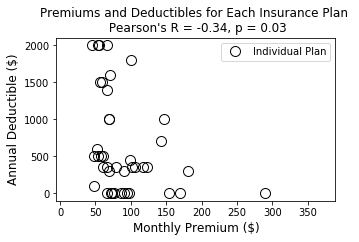

Premiums vs. Deductibles: HMOs vs. PPOs--------------------------------------------------

Both HMOs and FFSs follow the same trend as shown in all plans: as premiums increase, deductible decreases. 
However, plotting HMO and FFS plans separately shows some interesting takeaways by eye: 
For HMOs a monthly $50 premium can have a range of deductibles. And several different premiums offer a $0 deductible. 
For FFSs a monthly $50 premium can also have a range of deductibles. And several different premiums offer a $300 deductible. 
 FFSs are less likely to have $0 deductibles.


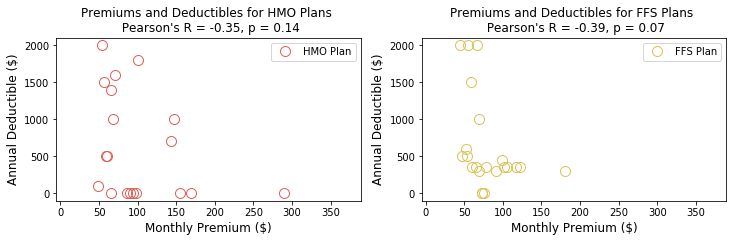

In [10]:
import scipy.stats as sstats
import seaborn as sns

fs = 10   # Set a variable for fontsize
ms = 10
current_palette = sns.color_palette("hls", 8)
xmin = df1['Premium'].min()-50
xmax = df1['Premium'].max()+100
ymin = df1['Deductible'].min()-100
ymax = df1['Deductible'].max()+100

'''
Premiums vs. Deductibles: All Plans
'''

print('Premiums vs. Deductibles: All plans' + '-'*50 + '\n')
print('Across all plans, as premiums increase, the deductible decreases')

r, p = sstats.pearsonr(df1['Premium'], df1['Deductible'])

plt.figure(figsize=(5,3))
plt.plot(df1['Premium'], df1['Deductible'], 'ko', markersize=ms, markerfacecolor='none', label='Individual Plan');
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.legend()
plt.xlabel('Monthly Premium ($)', fontsize=fs+2)
plt.ylabel('Annual Deductible ($)', fontsize=fs+2)
plt.title('Premiums and Deductibles for Each Insurance Plan \n Pearson\'s R = ' \
          + str(round(r,2)) + ', p = ' + str(round(p,2)), fontsize=fs+2)
plt.show()

#for i, txt in enumerate(df1['Code']):
#    plt.text(df1['Premium'].iloc[i], df1['Deductible'].iloc[i], str(df1['Code'].iloc[i]))

'''
Premiums vs. Deductibles: HMOs vs. PPOs
'''

print('Premiums vs. Deductibles: HMOs vs. PPOs' + '-'*50 + '\n')
print('Both HMOs and FFSs follow the same trend as shown in all plans: as premiums increase, deductible decreases. \n\
However, plotting HMO and FFS plans separately shows some interesting takeaways by eye: \n\
For HMOs a monthly $50 premium can have a range of deductibles. And several different premiums offer a $0 deductible. \n\
For FFSs a monthly $50 premium can also have a range of deductibles. And several different premiums offer a $300 deductible. \
\n FFSs are less likely to have $0 deductibles.')

r = np.empty([len(df1['Type'].unique())])
p = np.empty([len(df1['Type'].unique())])

plt.figure(figsize=(12,3))
for i, value_type in enumerate(df1['Type'].unique()):
    plt.subplot(1,2,i+1)
    # print(i, value_type)
    ind = df1['Type'] == value_type
    r[i], p[i] = sstats.pearsonr(df1['Premium'][ind], df1['Deductible'][ind])
    plt.plot(df1['Premium'][ind], df1['Deductible'][ind], 'o', markersize=ms, \
             markerfacecolor='none', markeredgecolor=current_palette[i], label=value_type + ' Plan')
    
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.legend()
    plt.xlabel('Monthly Premium ($)', fontsize=fs+2)
    plt.ylabel('Annual Deductible ($)', fontsize=fs+2)
    plt.title('Premiums and Deductibles for ' + value_type + ' Plans \n Pearson\'s R = ' \
              + str(round(r[i],2)) + ', p = ' + str(round(p[i],2)), fontsize=fs+2)
plt.show()

In [11]:
### Is there a relationship between deductible and out of pocket maximum?

# plot the relationship for each of the 7 variables

['Name', 'Type', 'Code', 'Premium', 'Deductible', 'OOP', 'Medical Account (HRA/HSA)', 'Referral_req', 'Primary_dollar', 'Primary_perc', 'Specialist_dollar', 'Specialist_perc', 'Inpatientsurg_dollar', 'Inpatientsurg_perc']
Premium vs. Deductible--------------------------------------------------

Dataframe size 574
0 HMO
1 FFS


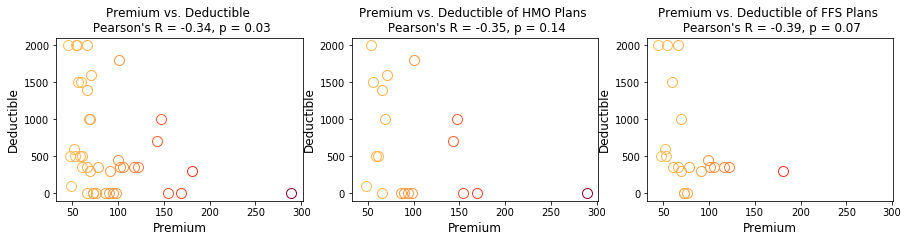

Premium vs. OOP--------------------------------------------------

Dataframe size 574
0 HMO
1 FFS


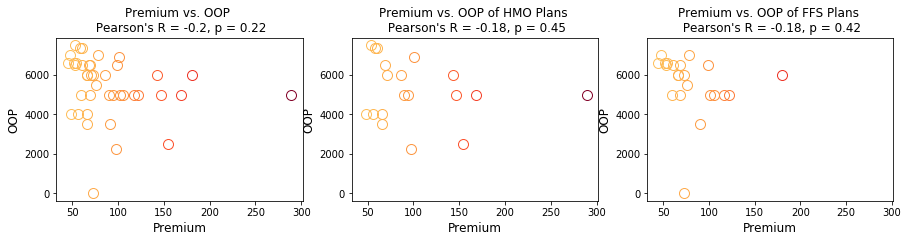

Premium vs. Medical Account (HRA/HSA)--------------------------------------------------

Dataframe size 574
0 HMO
1 FFS


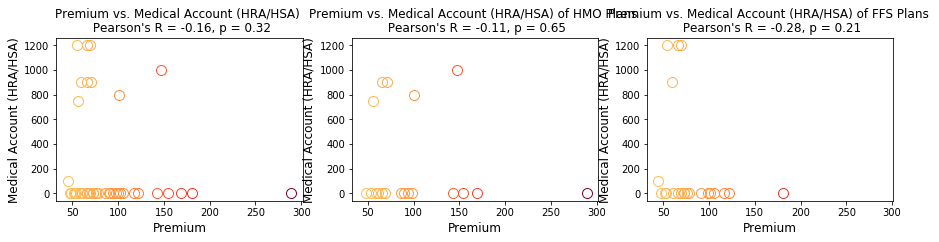

Premium vs. Referral_req--------------------------------------------------

Dataframe size 574
0 HMO
1 FFS


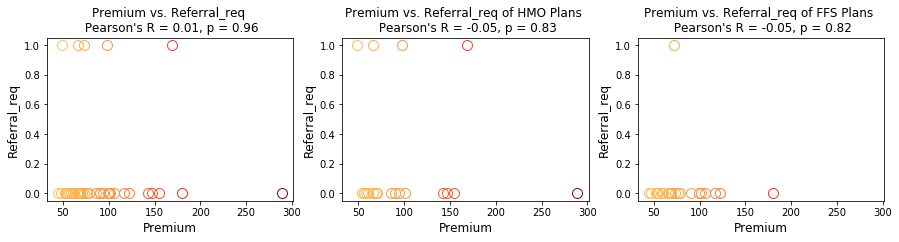

Premium vs. Primary_dollar--------------------------------------------------

Dataframe size 406
0 HMO
1 FFS


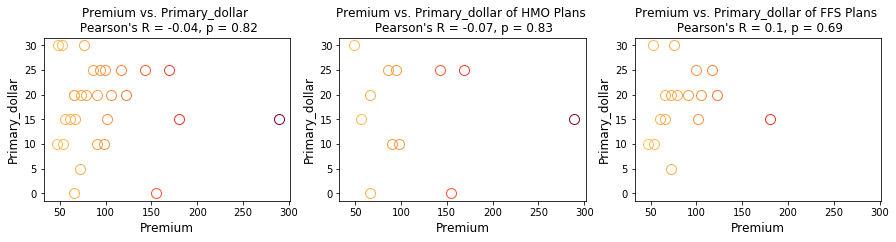

Premium vs. Primary_perc--------------------------------------------------

Dataframe size 210
0 HMO
1 FFS


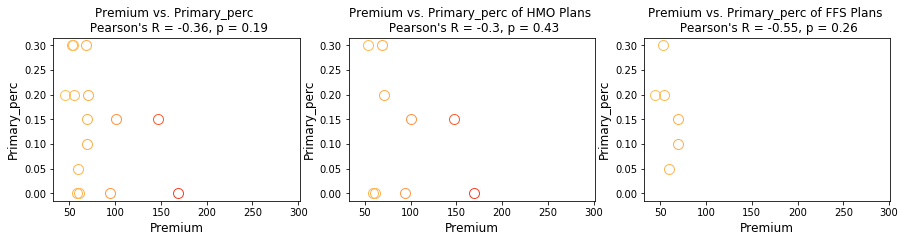

Premium vs. Specialist_dollar--------------------------------------------------

Dataframe size 434
0 HMO
1 FFS


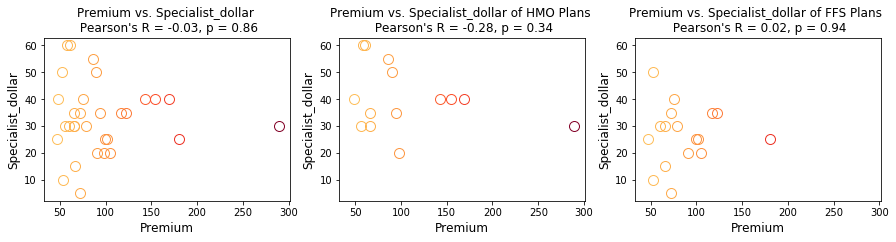

Premium vs. Specialist_perc--------------------------------------------------

Dataframe size 154
0 HMO
1 FFS


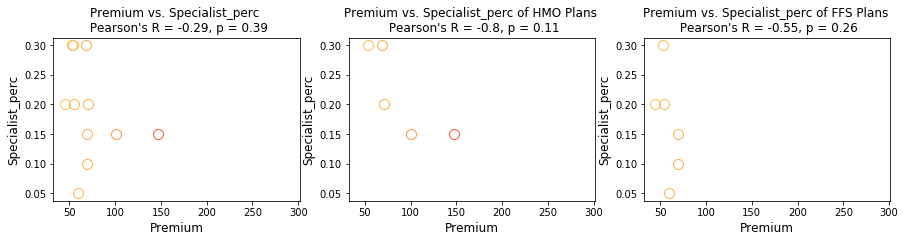

Premium vs. Inpatientsurg_dollar--------------------------------------------------

Dataframe size 56
0 FFS
1 HMO


C:\Users\lxc\Anaconda\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\lxc\Anaconda\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


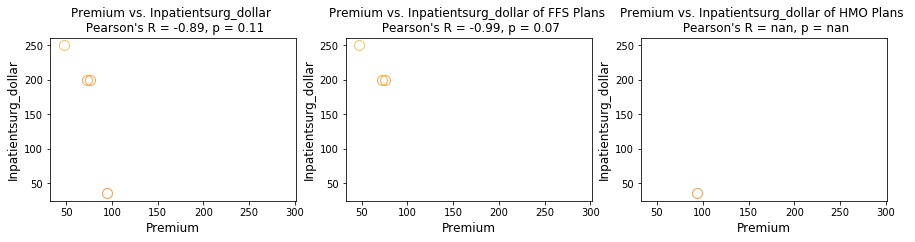

Premium vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 518
0 HMO
1 FFS


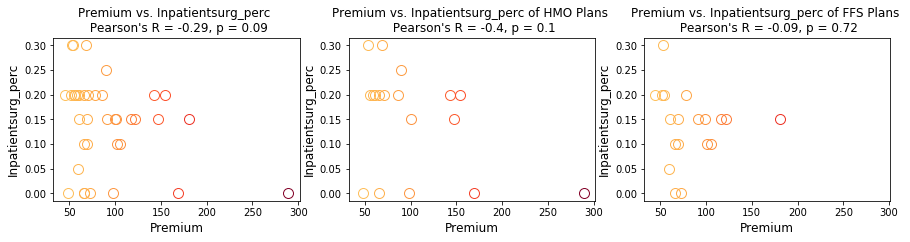

Deductible vs. OOP--------------------------------------------------

Dataframe size 574
0 HMO
1 FFS


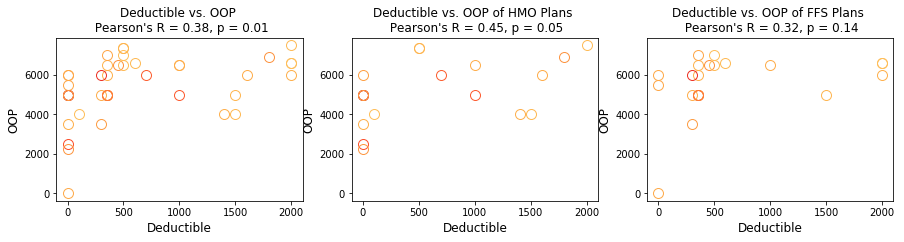

Deductible vs. Medical Account (HRA/HSA)--------------------------------------------------

Dataframe size 574
0 HMO
1 FFS


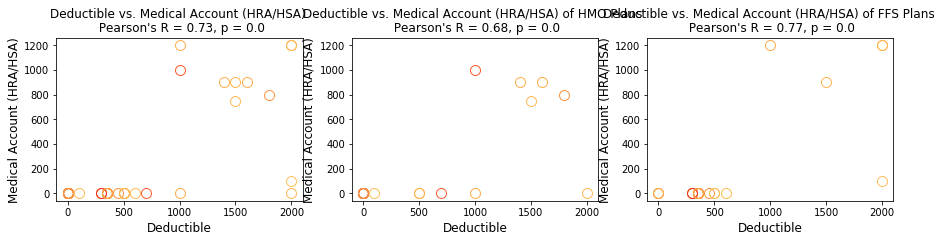

Deductible vs. Referral_req--------------------------------------------------

Dataframe size 574
0 HMO
1 FFS


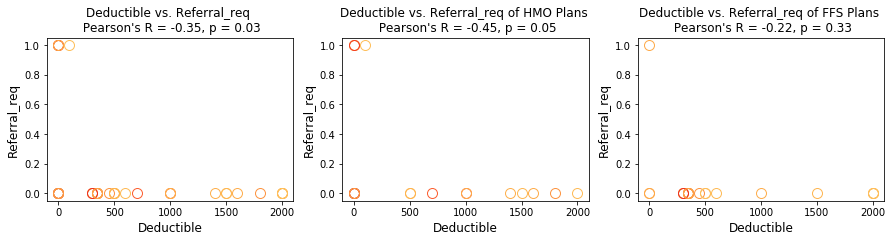

Deductible vs. Primary_dollar--------------------------------------------------

Dataframe size 406
0 HMO
1 FFS


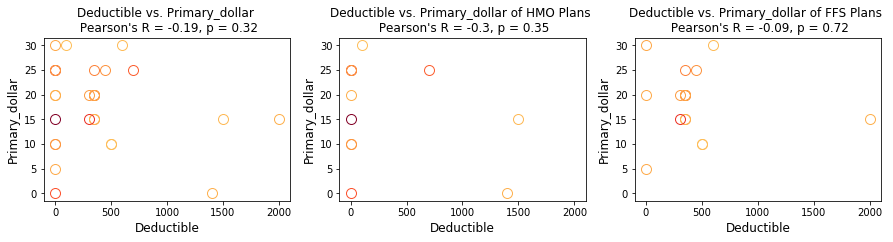

Deductible vs. Primary_perc--------------------------------------------------

Dataframe size 210
0 HMO
1 FFS


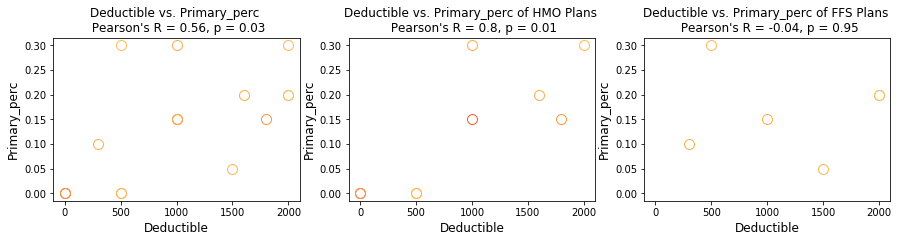

Deductible vs. Specialist_dollar--------------------------------------------------

Dataframe size 434
0 HMO
1 FFS


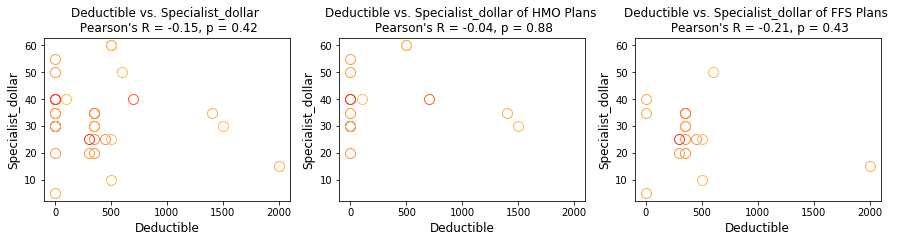

Deductible vs. Specialist_perc--------------------------------------------------

Dataframe size 154
0 HMO
1 FFS


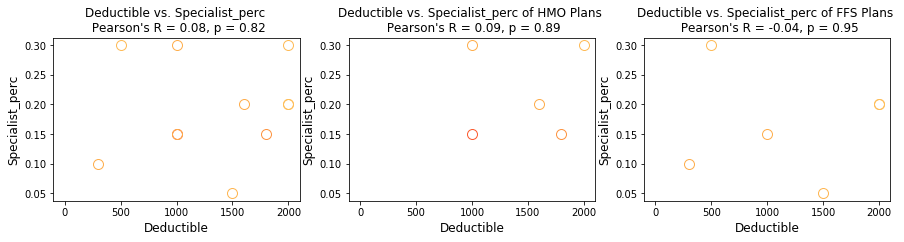

Deductible vs. Inpatientsurg_dollar--------------------------------------------------

Dataframe size 56
0 FFS
1 HMO


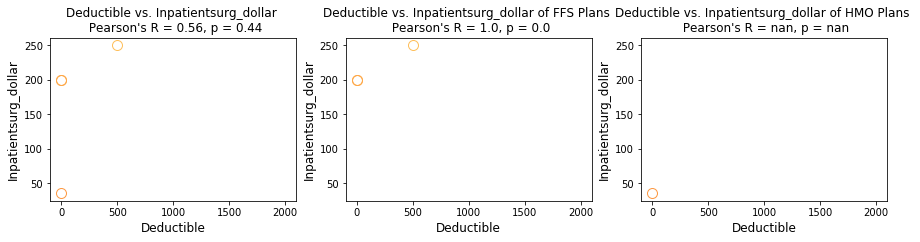

Deductible vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 518
0 HMO
1 FFS


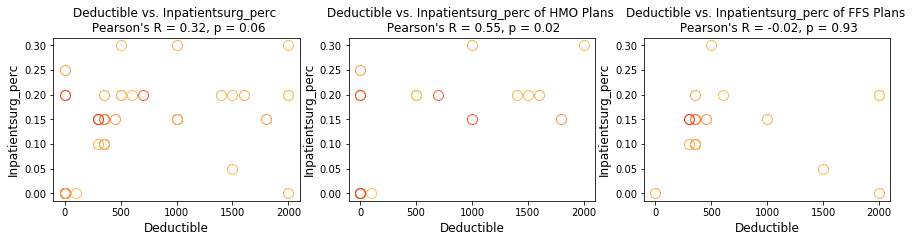

OOP vs. Medical Account (HRA/HSA)--------------------------------------------------

Dataframe size 574
0 HMO
1 FFS


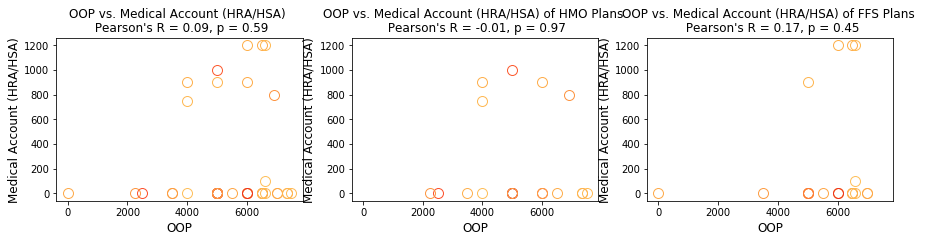

OOP vs. Referral_req--------------------------------------------------

Dataframe size 574
0 HMO
1 FFS


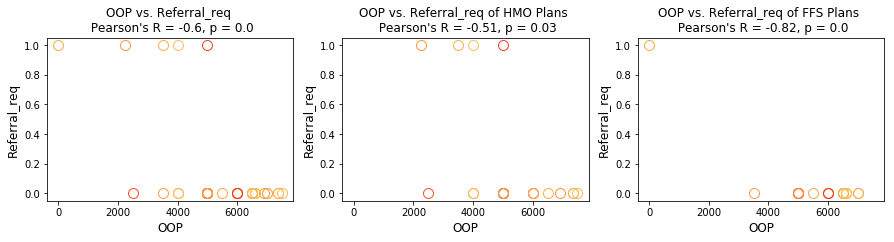

OOP vs. Primary_dollar--------------------------------------------------

Dataframe size 406
0 HMO
1 FFS


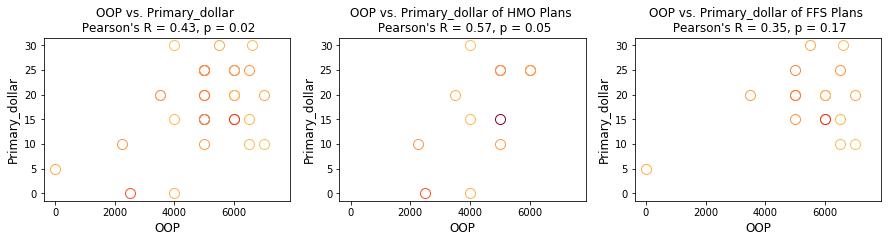

OOP vs. Primary_perc--------------------------------------------------

Dataframe size 210
0 HMO
1 FFS


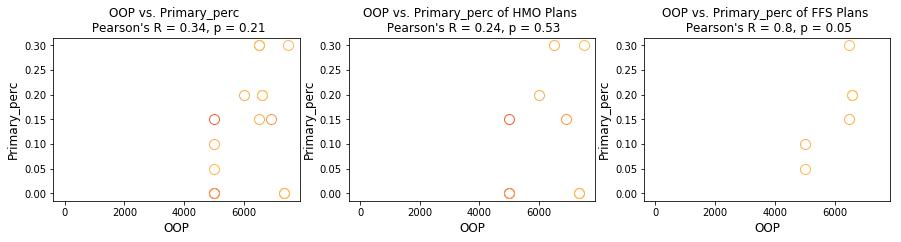

OOP vs. Specialist_dollar--------------------------------------------------

Dataframe size 434
0 HMO
1 FFS


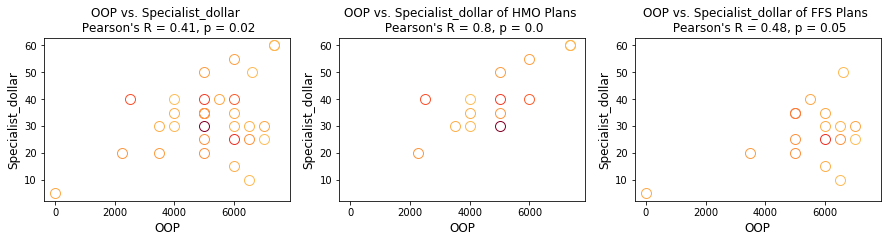

OOP vs. Specialist_perc--------------------------------------------------

Dataframe size 154
0 HMO
1 FFS


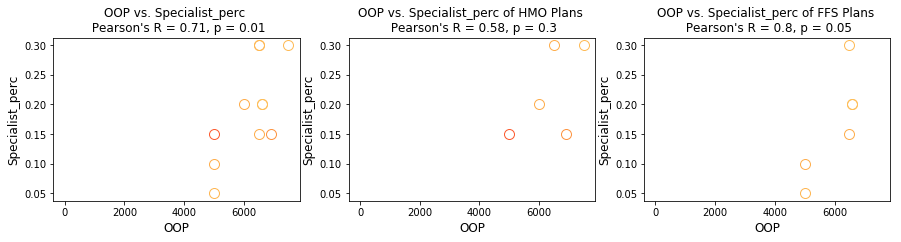

OOP vs. Inpatientsurg_dollar--------------------------------------------------

Dataframe size 56
0 FFS
1 HMO


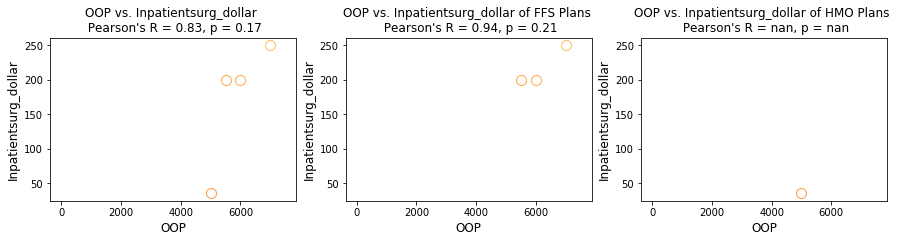

OOP vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 518
0 HMO
1 FFS


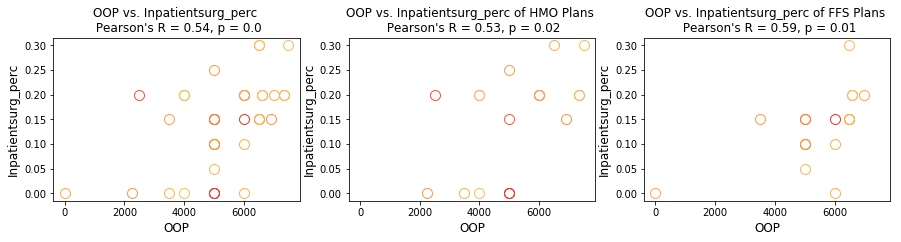

Medical Account (HRA/HSA) vs. Referral_req--------------------------------------------------

Dataframe size 574
0 HMO
1 FFS


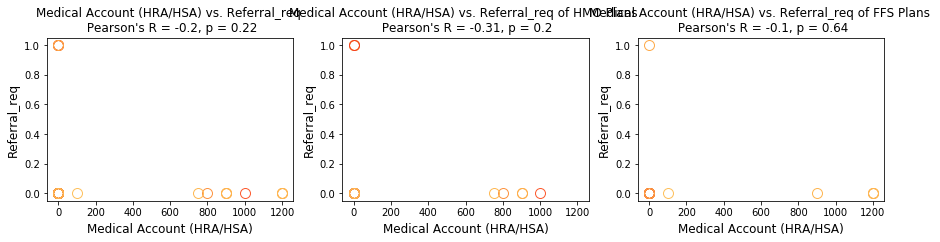

Medical Account (HRA/HSA) vs. Primary_dollar--------------------------------------------------

Dataframe size 406
0 HMO
1 FFS


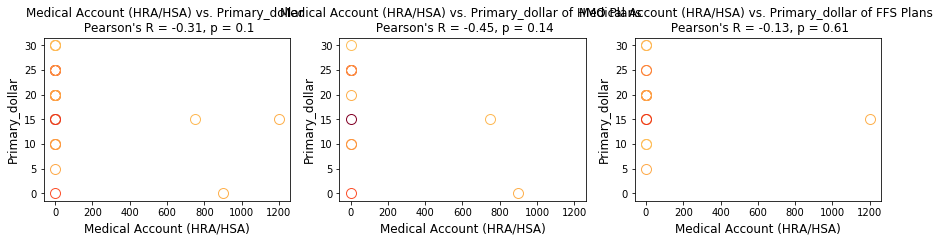

Medical Account (HRA/HSA) vs. Primary_perc--------------------------------------------------

Dataframe size 210
0 HMO
1 FFS


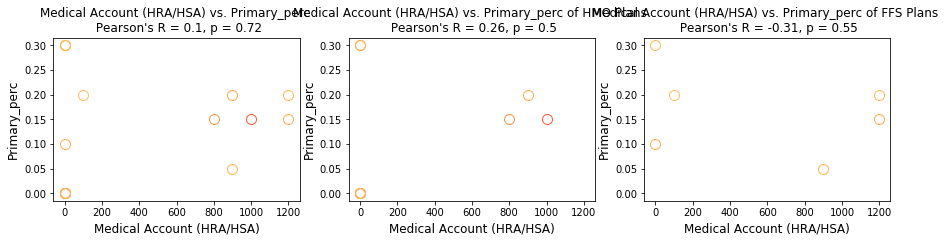

Medical Account (HRA/HSA) vs. Specialist_dollar--------------------------------------------------

Dataframe size 434
0 HMO
1 FFS


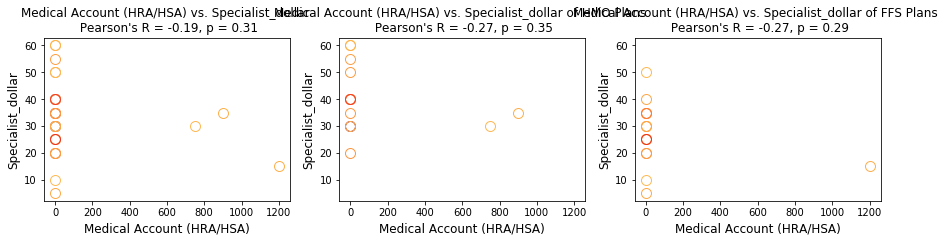

Medical Account (HRA/HSA) vs. Specialist_perc--------------------------------------------------

Dataframe size 154
0 HMO
1 FFS


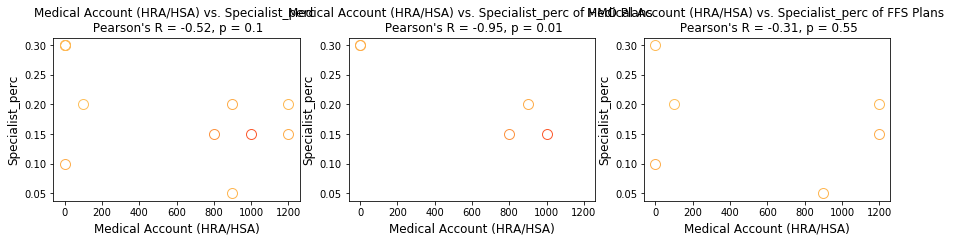

Medical Account (HRA/HSA) vs. Inpatientsurg_dollar--------------------------------------------------

Dataframe size 56
0 FFS
1 HMO


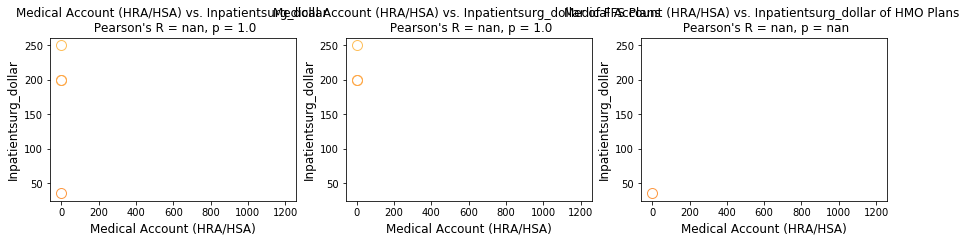

Medical Account (HRA/HSA) vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 518
0 HMO
1 FFS


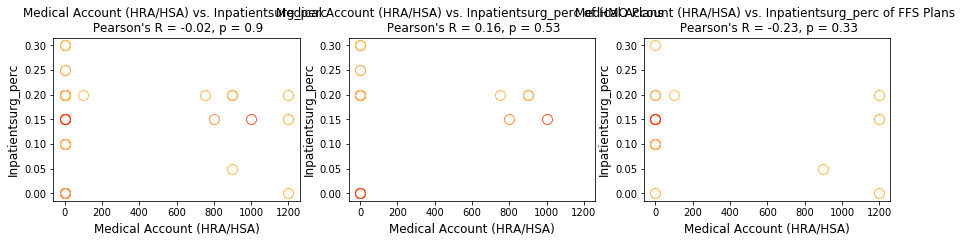

Referral_req vs. Primary_dollar--------------------------------------------------

Dataframe size 406
0 HMO
1 FFS


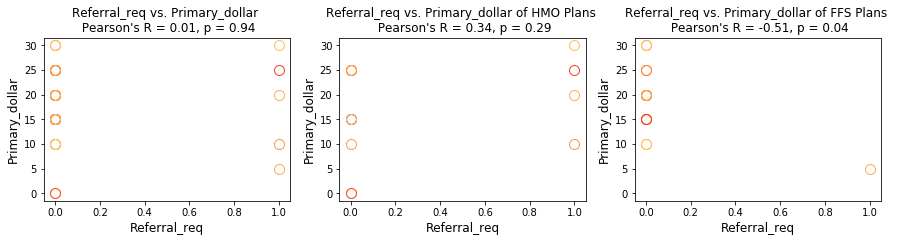

Referral_req vs. Primary_perc--------------------------------------------------

Dataframe size 210
0 HMO
1 FFS


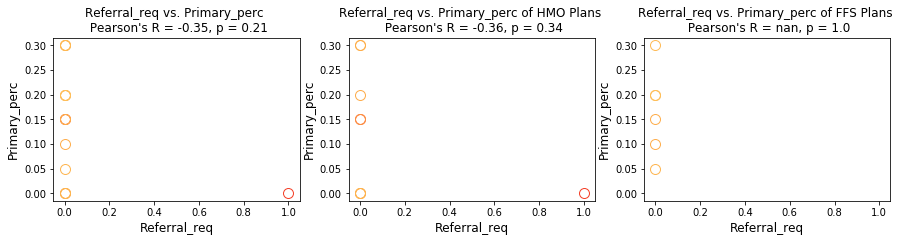

Referral_req vs. Specialist_dollar--------------------------------------------------

Dataframe size 434
0 HMO
1 FFS


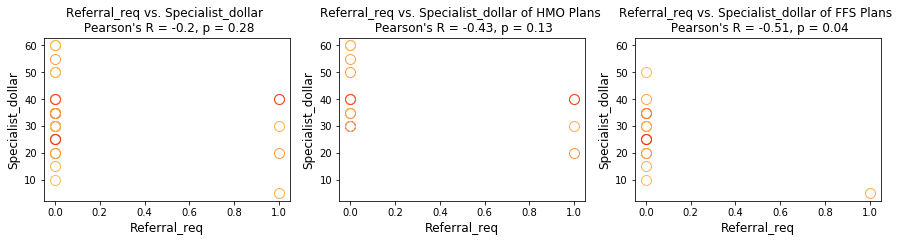

Referral_req vs. Specialist_perc--------------------------------------------------

Dataframe size 154
0 HMO
1 FFS


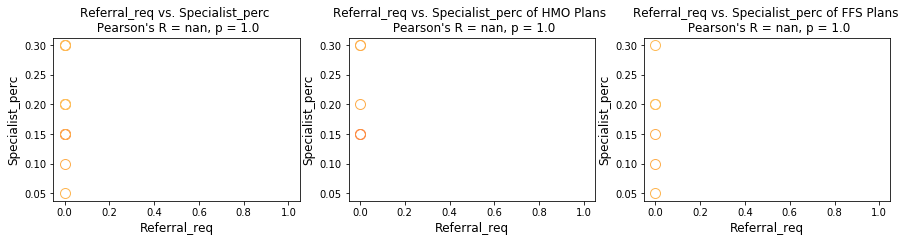

Referral_req vs. Inpatientsurg_dollar--------------------------------------------------

Dataframe size 56
0 FFS
1 HMO


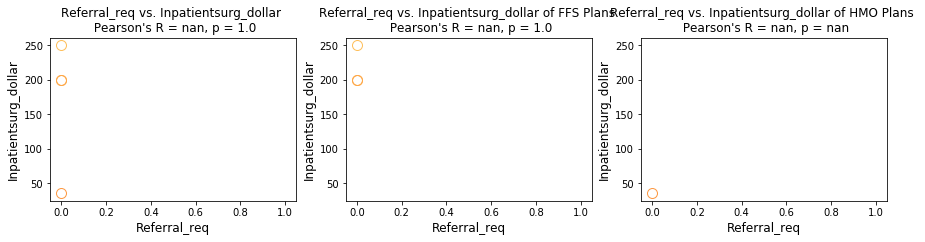

Referral_req vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 518
0 HMO
1 FFS


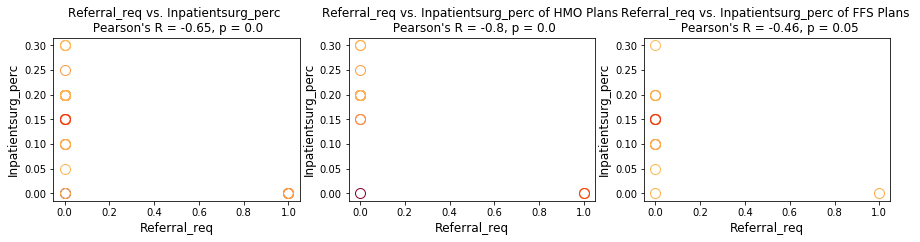

Primary_dollar vs. Primary_perc--------------------------------------------------

Dataframe size 42
0 FFS
1 HMO


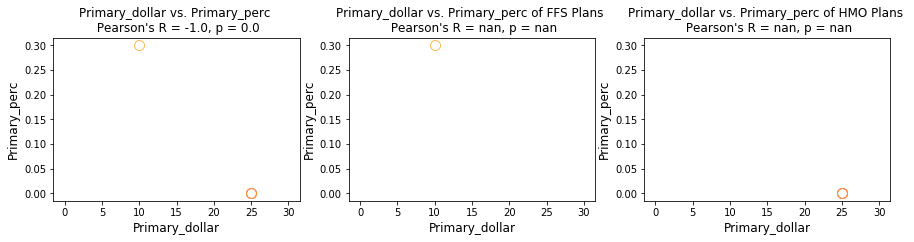

Primary_dollar vs. Specialist_dollar--------------------------------------------------

Dataframe size 406
0 HMO
1 FFS


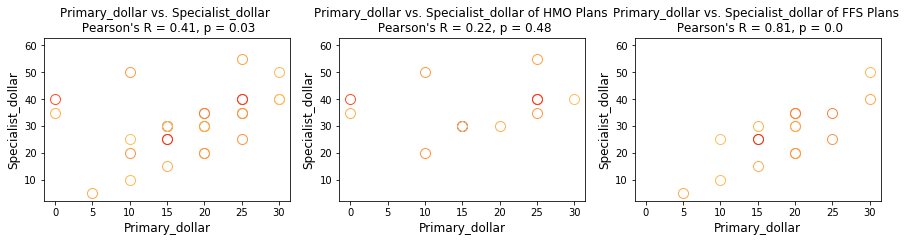

Primary_dollar vs. Specialist_perc--------------------------------------------------

Dataframe size 14
0 FFS


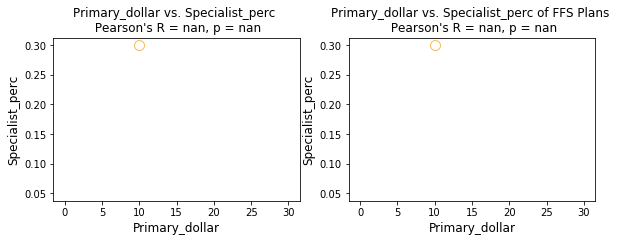

Primary_dollar vs. Inpatientsurg_dollar--------------------------------------------------

Dataframe size 56
0 FFS
1 HMO


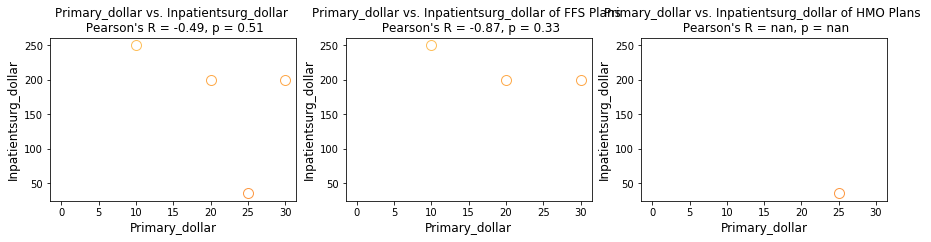

Primary_dollar vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 350
0 HMO
1 FFS


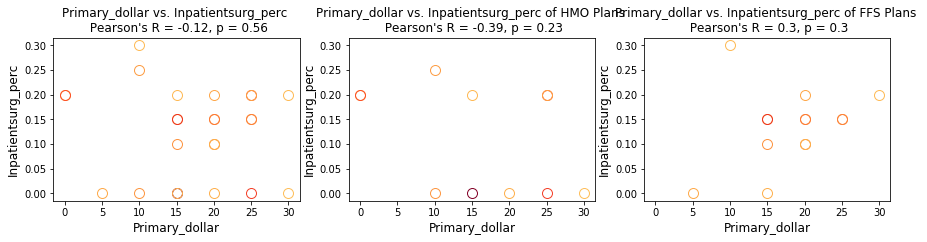

Primary_perc vs. Specialist_dollar--------------------------------------------------

Dataframe size 70
0 FFS
1 HMO


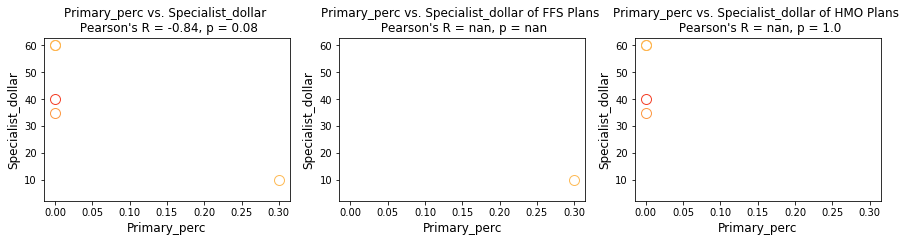

Primary_perc vs. Specialist_perc--------------------------------------------------

Dataframe size 154
0 HMO
1 FFS


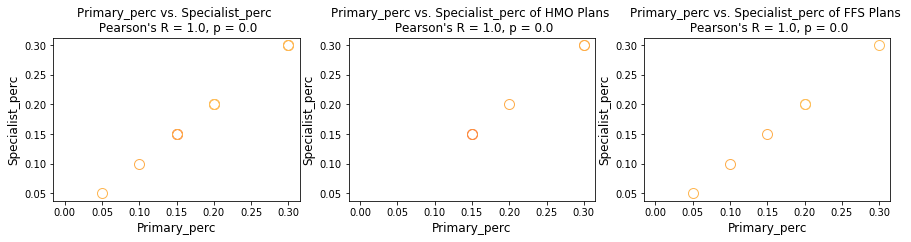

Primary_perc vs. Inpatientsurg_dollar--------------------------------------------------

Dataframe size 14
0 HMO


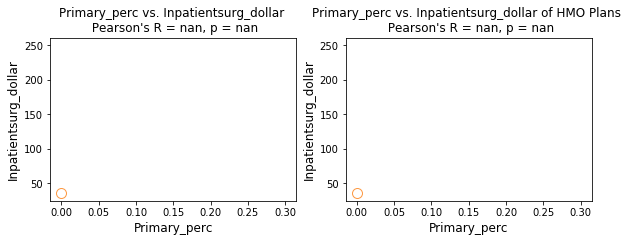

Primary_perc vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 196
0 HMO
1 FFS


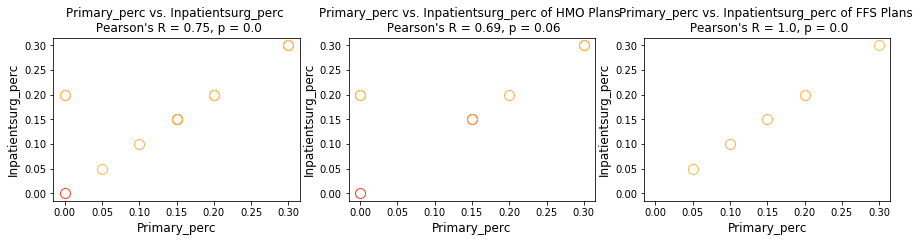

Specialist_dollar vs. Specialist_perc--------------------------------------------------

Dataframe size 14
0 FFS


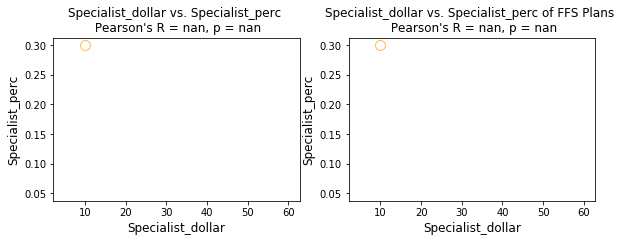

Specialist_dollar vs. Inpatientsurg_dollar--------------------------------------------------

Dataframe size 56
0 FFS
1 HMO


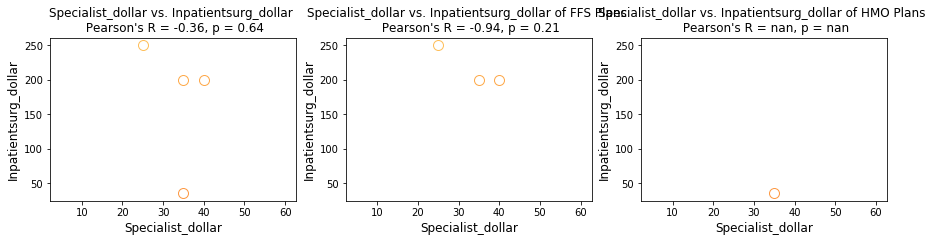

Specialist_dollar vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 378
0 HMO
1 FFS


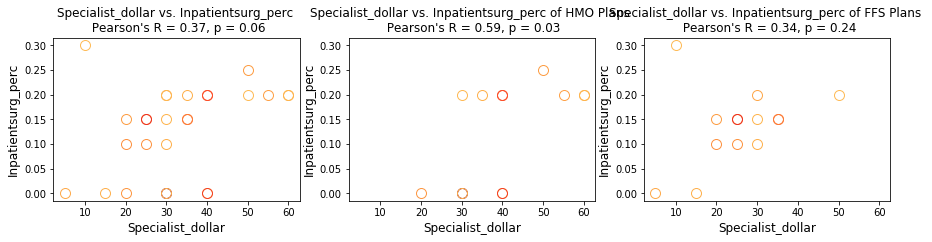

Specialist_perc vs. Inpatientsurg_dollar--------------------------------------------------

Dataframe size 0


C:\Users\lxc\Anaconda\lib\site-packages\scipy\stats\stats.py:3005: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
C:\Users\lxc\Anaconda\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lxc\Anaconda\lib\site-packages\scipy\stats\stats.py:3006: RuntimeWarning: Mean of empty slice.
  my = y.mean()


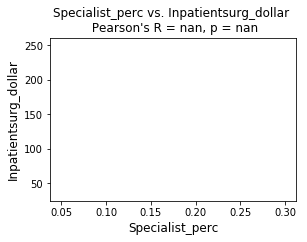

Specialist_perc vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 154
0 HMO
1 FFS


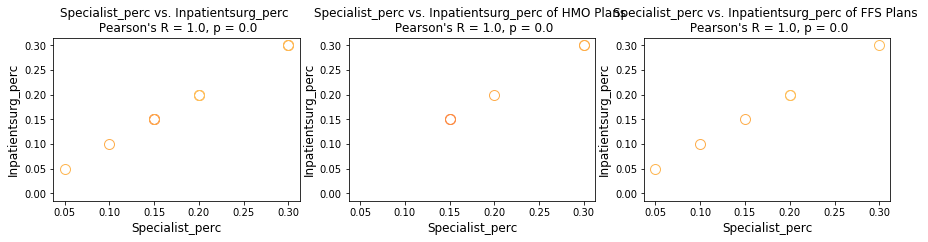

Inpatientsurg_dollar vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 0


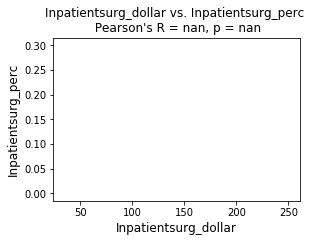

In [12]:
def plot_color(x, y, H, df):
    # x, y, color_ratio are lists or columns in a df
    current_palette = sns.color_palette("YlOrRd", 150)    # other color palettes: "CMRmap"
    current_palette = current_palette[49:]
    
    ms = 10   # Markersize
    
    x = x.reset_index(drop=True)
    y = y.reset_index(drop=True)    
    H = H.reset_index(drop=True)
    
    hmax = max(df['Premium'])   # Need to normalize premium to all premiums (not just subset)
    hmin = min(df['Premium'])
    H_diff = hmax - hmin

    for m, val in enumerate(x):
        ratio = (H[m]-hmin)/H_diff
        #print('H[m]', H[m], hmin, H_diff)
        #print('ratio', ratio)
        plt.plot(x[m], y[m], 'o', markersize=ms, markerfacecolor='none', markeredgecolor=current_palette[int(ratio*100)])
        
def plot_2features(df, column1, column2, column_groupby):
    # Input: df, column1, column2
    # Plot: df[column1] vs. df[column2] for HMO and FFS
    # Return: pass
    df_orig = copy.deepcopy(df)
    print(column1 + ' vs. ' + column2 + '-'*50 + '\n')
    
    current_palette = sns.color_palette("CMRmap", 150)  # Create the color palette
    fs = 10   # Set a variable for fontsize
    ms = 10
    current_palette = sns.color_palette("hls", 8)
    xmin = df[column1].min() - (df[column1].max()-df[column1].min())*0.05
    xmax = df[column1].max() + (df[column1].max()-df[column1].min())*0.05
    ymin = df[column2].min() - (df[column2].max()-df[column2].min())*0.05
    ymax = df[column2].max() + (df[column2].max()-df[column2].min())*0.05
    
    # find correlation
    df = df.dropna(subset = [column1])
    df = df.dropna(subset = [column2])
    print('Dataframe size', df.size)
    r, p = sstats.pearsonr(df[column1], df[column2])

    plt.figure(figsize=(15,3))
    plt.subplot(1,3,1)
    
    #plt.plot(df[column1], df[column2], 'o', label='Individual Plan');
    plot_color(df[column1], df[column2], df['Premium'], df_orig)
    
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    #plt.legend()
    plt.xlabel(column1, fontsize=fs+2)
    plt.ylabel(column2, fontsize=fs+2)
    plt.title(column1 + ' vs. ' + column2 + ' \n Pearson\'s R = ' \
              + str(round(r,2)) + ', p = ' + str(round(p,2)), fontsize=fs+2)

    # Plot for HMO and FFS separately
    r = np.empty([len(df[column_groupby].unique())])
    p = np.empty([len(df[column_groupby].unique())])

    #plt.figure(figsize=(12,3))
    for i, value_type in enumerate(df[column_groupby].unique()):
        plt.subplot(1,3,i+2)
        print(i, value_type)
        ind = df[column_groupby] == value_type
        
        # Find correlation
        r[i], p[i] = sstats.pearsonr(df[column1][ind], df[column2][ind])
        
        # Plot
        plot_color(df[column1][ind], df[column2][ind], df['Premium'][ind], df_orig)
        #plt.plot(df[column1][ind], df[column2][ind], 'o', markersize=ms, \
        #         markerfacecolor='none', markeredgecolor=current_palette[i], label=value_type + ' Plan')
        
        plt.xticks(fontsize=fs)
        plt.yticks(fontsize=fs)
        plt.xlim(xmin,xmax)
        plt.ylim(ymin,ymax)
        #plt.legend()
        plt.xlabel(column1, fontsize=fs+2)
        plt.ylabel(column2, fontsize=fs+2)
        plt.title(column1 + ' vs. ' + column2 + ' of ' + value_type + ' Plans \n Pearson\'s R = ' \
                  + str(round(r[i],2)) + ', p = ' + str(round(p[i],2)), fontsize=fs+2)
    plt.show()

features = list(df1.columns)
print(features)

j = 4
for f1 in features[3:]:
    for f2 in features[j:]:
        plot_2features(df1, f1, f2, 'Type')
    j=j+1


In [61]:
df1_np = copy.deepcopy(df1)
df1_np = df1_np.drop(columns=['Name', 'Type', 'Code'])
df1_np.corr()


,Premium,Deductible,OOP,Medical Account (HRA/HSA),Referral_req,Primary_dollar,Primary_perc,Specialist_dollar,Specialist_perc,Inpatientsurg_dollar,Inpatientsurg_perc
Premium,1.000000,-0.342620,-0.197830,-0.159607,0.008213,-0.043982,-0.358555,-0.032905,-0.287010,-0.890120,-0.286449
Deductible,-0.342620,1.000000,0.381316,0.725422,-0.345794,-0.192953,0.564750,-0.149517,0.075951,0.559453,0.316591
OOP,-0.197830,0.381316,1.000000,0.086022,-0.602481,0.425778,0.340425,0.406537,0.711135,0.834555,0.536397
Medical Account (HRA/HSA),-0.159607,0.725422,0.086022,1.000000,-0.196763,-0.309654,0.100794,-0.188373,-0.524967,NaN,-0.020962
Referral_req,0.008213,-0.345794,-0.602481,-0.196763,1.000000,0.013686,-0.345425,-0.199139,NaN,NaN,-0.652478
Primary_dollar,-0.043982,-0.192953,0.425778,-0.309654,0.013686,1.000000,-1.000000,0.406435,NaN,-0.491373,-0.121531
Primary_perc,-0.358555,0.564750,0.340425,0.100794,-0.345425,-1.000000,1.000000,-0.835704,1.000000,NaN,0.749787
Specialist_dollar,-0.032905,-0.149517,0.406537,-0.188373,-0.199139,0.406435,-0.835704,1.000000,NaN,-0.363450,0.369667
Specialist_perc,-0.287010,0.075951,0.711135,-0.524967,NaN,NaN,1.000000,NaN,1.000000,NaN,1.000000
Inpatientsurg_dollar,-0.890120,0.559453,0.834555,NaN,NaN,-0.491373,NaN,-0.363450,NaN,1.000000,NaN


(array([12., 10.,  5.,  2.,  0.,  3.,  0.,  3.,  1.,  5.]),
 array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800., 2000.]),
 <a list of 10 Patch objects>)

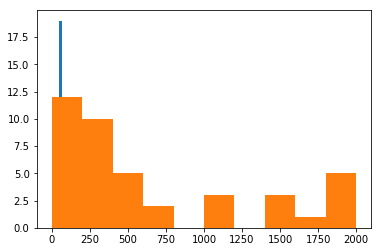

In [14]:
counts, bins = np.histogram(df1['Premium'])
plt.hist(bins[:-1], bins, weights=counts)

counts, bins = np.histogram(df1['Deductible'])
plt.hist(bins[:-1], bins, weights=counts)

### Running PCA

* Fill NaN values with the mean of the column
* Normalize

In [64]:
from sklearn import preprocessing

# Fill NA
df1_np = df1_np.fillna(df1_np.mean())

# Normalize
x = df1_np.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df1_train = pd.DataFrame(x_scaled)

df1_train

,0,1,2,3,4,5,6,7,8,9,10
0,0.035513,1.000,1.000000,0.000000,0.0,0.591954,1.000000,0.507331,1.000000,0.633721,1.000000
1,0.417765,0.500,0.666667,0.833333,0.0,0.591954,0.500000,0.507331,0.400000,0.633721,0.500000
2,0.400295,0.350,0.800000,0.000000,0.0,0.833333,0.466667,0.636364,0.563636,0.633721,0.666667
3,0.105761,0.800,0.800000,0.750000,0.0,0.591954,0.666667,0.507331,0.600000,0.633721,0.666667
4,0.228132,0.900,0.920000,0.666667,0.0,0.591954,0.500000,0.507331,0.400000,0.633721,0.500000
5,0.168276,0.000,0.800000,0.000000,0.0,0.833333,0.466667,0.909091,0.563636,0.633721,0.666667
6,1.000000,0.000,0.666667,0.000000,0.0,0.500000,0.466667,0.454545,0.563636,0.633721,0.000000
7,0.097537,0.500,0.866667,0.000000,0.0,0.591954,1.000000,0.507331,1.000000,0.633721,1.000000
8,0.098683,0.500,0.866667,1.000000,0.0,0.591954,0.500000,0.507331,0.400000,0.633721,0.500000
9,0.223263,0.225,0.866667,0.000000,0.0,0.833333,0.466667,0.363636,0.563636,0.633721,0.500000


Let's do some unsupervised learning clustering! 


Training matrix shape: (41, 11)
PC variance explained: [0.36768677 0.22661853 0.13291059]


<Figure size 432x288 with 0 Axes>

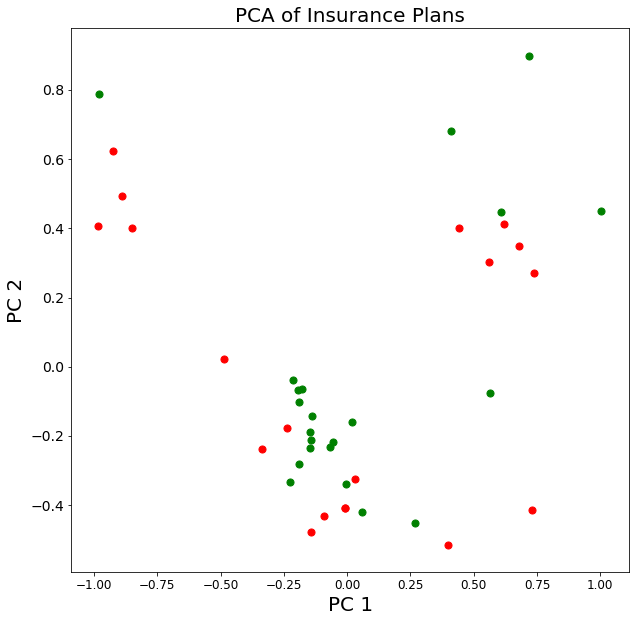

In [72]:
# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print('Training matrix shape:', df1_train.shape)

pca_plans = PCA(n_components=3)

pca_results = pca_plans.fit_transform(df1_train)

pca_res_df = pd.DataFrame(data = pca_results
             , columns = ['PC1', 'PC2', 'PC3'])

print('PC variance explained:', format(pca_plans.explained_variance_ratio_))

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('PC 1',fontsize=20)
plt.ylabel('PC 2',fontsize=20)
plt.title("PCA of Insurance Plans",fontsize=20)
targets = ['HMO', 'FFS']
colors = ['r', 'g']

#plt.scatter(pca_res_df.loc[temp,'PC1'], pca_res_df.loc[temp,'PC2'], c='b')
for target, color in zip(targets,colors):   
    ind = df1['Type'] == target
    plt.scatter(pca_res_df.loc[ind, 'PC1'],
               pca_res_df.loc[ind, 'PC2'], c = color, s = 50)


PCA Weights --------------------
         PC1       PC2       PC3
0   0.728734 -0.413709  0.603785
1   0.443518  0.400163 -0.201650
2   0.029264 -0.323147 -0.133689
3   0.737797  0.271777  0.050703
4   0.678335  0.348533 -0.162417
5  -0.141713 -0.477380 -0.256873
6  -0.486170  0.022484 -0.126882
7   0.398406 -0.514579  0.579927
8   0.608879  0.446114 -0.244894
9  -0.067896 -0.230936 -0.060163
10 -0.227028 -0.332827 -0.216443
11  0.267692 -0.450624  0.838488
12 -0.148530 -0.234142 -0.109367
13 -0.090468 -0.431244  0.031515
14  0.620022  0.411773  0.178339
15 -0.238963 -0.177765  0.240917
16 -0.180402 -0.064600  0.066949
17 -0.214280 -0.039214 -0.231820
18  0.412023  0.681704 -0.538316
19 -0.193954 -0.068053  0.039620
20 -0.056101 -0.216036  0.040407
21  0.017833 -0.159002  0.168163
22 -0.191825 -0.281811 -0.061616
23 -0.852078  0.400687 -0.026942
24 -0.926812  0.623568  0.403346
25 -0.888915  0.492640  0.179235
26 -0.983152  0.407527 -0.305997
27 -0.140027 -0.142408 -0.047028
28  0.0570

<Figure size 432x288 with 0 Axes>

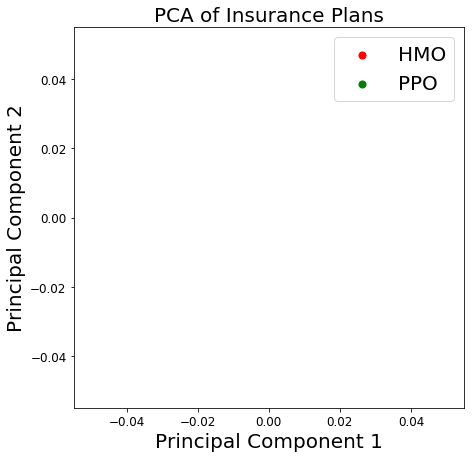

In [67]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Column to predict
predict = 'Type'

# PCA
pca_model = PCA(n_components=3)

pca_results = pca_model.fit_transform(df1_train)

pca_weights = pd.DataFrame(data = pca_results
             , columns = ['PC1', 'PC2', 'PC3'])
print('PCA Weights', '-'*20)
print(pca_weights)

print(format(pca_model.explained_variance_ratio_))

print('PCA Figure', '-'*20)

plt.figure()
plt.figure(figsize=(7,7))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Principal Component 1',fontsize=20)
plt.ylabel('Principal Component 2',fontsize=20)
plt.title("PCA of Insurance Plans",fontsize=20)
colors = ['r', 'g']
targets = [1, 0]
target_labels = ['HMO', 'PPO']
#temp = df1['Type'] == 1

#print(temp)

#plt.scatter(pca_res_df.loc[temp,'PC1'], pca_res_df.loc[temp,'PC2'], c='b')
for target, color in zip(targets,colors):   
    indicesToKeep = df1['Type'] == target
    plt.scatter(pca_weights.loc[indicesToKeep, 'PC1']
               , pca_weights.loc[indicesToKeep, 'PC2'], c = color, s = 50)

plt.legend(target_labels,prop={'size': 20})




Matrix used to train --------------------
     0         1      2         3         4    5         6         7   \
0   1.0  0.035513  1.000  1.000000  0.000000  0.0  0.591954  1.000000   
1   1.0  0.417765  0.500  0.666667  0.833333  0.0  0.591954  0.500000   
2   1.0  0.400295  0.350  0.800000  0.000000  0.0  0.833333  0.466667   
3   1.0  0.105761  0.800  0.800000  0.750000  0.0  0.591954  0.666667   
4   1.0  0.228132  0.900  0.920000  0.666667  0.0  0.591954  0.500000   
5   1.0  0.168276  0.000  0.800000  0.000000  0.0  0.833333  0.466667   
6   1.0  1.000000  0.000  0.666667  0.000000  0.0  0.500000  0.466667   
7   1.0  0.097537  0.500  0.866667  0.000000  0.0  0.591954  1.000000   
8   0.0  0.098683  0.500  0.866667  1.000000  0.0  0.591954  0.500000   
9   0.0  0.223263  0.225  0.866667  0.000000  0.0  0.833333  0.466667   
10  0.0  0.127240  0.000  0.733333  0.000000  0.0  1.000000  0.466667   
11  0.0  0.033958  0.250  0.866667  0.000000  0.0  0.333333  1.000000   
12  0.0  

<Figure size 432x288 with 0 Axes>

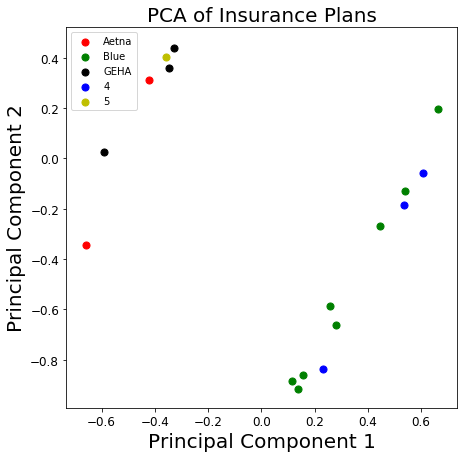

In [175]:
# Column to predict
predict = 'Name'

# df1 to nparray
df1_train = copy.deepcopy(df1)

df1['Name'] = df1['Name'].astype('category')
df1['Name'] = df1['Name'].cat.codes
df1_train['Name'] = df1_train['Name'].astype('category')
df1_train['Name'] = df1_train['Name'].cat.codes
df1_train = df1_train.drop(columns = 'Code')
df1_train = df1_train.drop(columns = predict)

df1_train

x = df1_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df1_train = pd.DataFrame(x_scaled)

print('Matrix used to train', '-'*20)
print(df1_train)

# PCA
pca_model = PCA(n_components=3)

pca_results = pca_model.fit_transform(df1_train)

pca_weights = pd.DataFrame(data = pca_results
             , columns = ['PC1', 'PC2', 'PC3'])
print('PCA Weights', '-'*20)
print(pca_weights)

print(format(pca_model.explained_variance_ratio_))

print('PCA Figure', '-'*20)

plt.figure()
plt.figure(figsize=(7,7))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Principal Component 1',fontsize=20)
plt.ylabel('Principal Component 2',fontsize=20)
plt.title("PCA of Insurance Plans",fontsize=20)
colors = ['r', 'g', 'k', 'b', 'y']
targets = [0, 1, 2, 3, 4, 5, 6]
target_labels = ['Aetna', 'Blue', 'GEHA', '4', '5', '6']
#temp = df1['Type'] == 1

#print(temp)

#plt.scatter(pca_res_df.loc[temp,'PC1'], pca_res_df.loc[temp,'PC2'], c='b')
for target, color in zip(targets,colors):   
    indicesToKeep = df1['Name'] == target
    plt.scatter(pca_weights.loc[indicesToKeep, 'PC1']
               , pca_weights.loc[indicesToKeep, 'PC2'], c = color, s = 50)

plt.legend(target_labels,prop={'size': 10})


## Can we recover HMO vs. PPO groups using unsupervised learning? 